In [1]:
import timeit
import numpy as np
import jax.numpy as jnp
from jax import random, vmap, jit
import jax.scipy.stats.gamma as jgamma
import numpyro
import numpyro.distributions as dist
from numpyro.diagnostics import hpdi
from numpyro.infer import MCMC, NUTS, HMC, BarkerMH
from IPython.display import IFrame

import matplotlib.pyplot as plt
import matplotlib as mpl
import os

mpl.rc("figure", figsize=(10, 10))
os.environ["PROJ_LIB"] = "C:\\Utilities\\Python\\Anaconda\\Library\\share"

from src.model_fitting_functions import BernoulliGamma

# What is JAX?

Accelerated Numpy - Works on GPUs

In [2]:
IFrame(src="https://www.youtube.com/embed/0mVmRHMaOJ4", width=600, height=300)

Uses Accelerated Linear Algebra (XLA) - Compiles and runs numpy programs on GPUs

JIT compilation of custom functions. 
grad, jit, pmap, vmap

# What is Numpyro

https://github.com/pyro-ppl/numpyro

MCMC with JAX (Pyro with JAX rather than pytorch)

# Example

In [3]:
jan_data = np.load(
    "/data/notebooks/jupyterlab-biascorrlab/data/multi_site_jan_precip.npy"
)  # This is 38 years of daily data for January

feb_data = np.load(
    "/data/notebooks/jupyterlab-biascorrlab/data/multi_site_feb_precip.npy"
)  # This is 38 years of daily data for February

In [4]:
jdata = jnp.array([jan_data[:1000, :], feb_data[:1000, :]]) #JAX Device Array

In [5]:
jdata = np.moveaxis(jdata, 1, 0)
jdata.shape

(1000, 2, 5)

Bayesian Inference:

$Posterior = \dfrac{Likelihood \cdot Prior}{Normalising Constant} $

$P(\boldsymbol{p,\alpha,\beta}|\boldsymbol{y}) = \dfrac{P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta}) \cdot P(\boldsymbol{\boldsymbol{p,\alpha,\beta}})}{P(\boldsymbol{y})} $

---

Likelihood:

$P(Y_{jk}=y_{jk}) = B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk})$

$B(1,p_{jk})\cdot G(y_{jk}|\alpha_{jk},\beta_{jk}) = \ p_{jk} \cdot \dfrac{{\beta_{jk}}^{\alpha_{jk}} y_{jk}^{\alpha_{jk}-1}e^{-\beta_{jk} y_{jk}}}{\Gamma(\alpha_{jk})} \} \text{Rainfall} $ 

$\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ (1-p_{jk}) \ \ \ \ \ \ \ \ \ \ \ \} \text{No Rainfall}$

Modelling correlation between parameters:

$\beta_{jk} \sim  LN(a_0+a_1 \cdot \alpha_{jk},\sigma^{2})$

The set of parameters $[a_0,a_1,\sigma]$ are hyper-parameters, in that they are not dependent on j or k.

$Likelihood = P(\boldsymbol{Y}|\boldsymbol{p},\boldsymbol{\alpha},\beta) = \prod_\limits{jk}P(Y_{jk}|p_{jk},\alpha_{jk},a_{0},a_{1},{\sigma}^2) = \prod_\limits{ijk} B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0},a_{1},{\sigma}^2)$

$Log Likehood = Log(\prod_\limits{ijk} B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0},a_{1},{\sigma}^2)) = \sum_\limits{ijk} Log(B(1,p_{jk})\cdot G(y_{i}|\alpha_{jk},a_{0},a_{1},{\sigma}^2))$

---

Posterior

Numerator: $P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta}) = \prod_{i} B(1,p)\cdot G(y_{i}|\alpha,\beta)\cdot P(p,\alpha,\beta)$

Denominator: $P(\boldsymbol{y}) = \iiint\limits_{\theta} P(\boldsymbol{y}|\boldsymbol{p,\alpha,\beta})\cdot P(\boldsymbol{p,\alpha,\beta}) \,dp\,d\alpha\,d\beta$

# MCMC 

https://towardsdatascience.com/mcmc-intuition-for-everyone-5ae79fff22b1

In [6]:
IFrame(src="https://www.youtube.com/embed/yApmR-c_hKU", width=600, height=300)

# The Model

In [7]:
def parametric_dependency_model(jdata):

    # Hyper-Params: (These are used to describe the relationship between alpha and the scale parameter from the Bernoulli-Gamma dist.)
    a0 = numpyro.sample("a0", dist.Uniform(-10, 10.0))
    a1 = numpyro.sample("a1", dist.Uniform(-10, 10.0))
    betavar = numpyro.sample("betavar", dist.InverseGamma(0.001, 0.001))
    
    # Number of Months and Sites
    months = jdata.shape[1]
    sites = jdata.shape[2]

    with numpyro.plate("Months", months, dim=-2) as k:
        with numpyro.plate("Sites", sites, dim=-1) as j:
            
            # Bernoulli-Gamma Params
            p = numpyro.sample("p", dist.Uniform(0.01, 0.99))
            alpha = numpyro.sample("alpha", dist.Gamma(0.001, 0.001))
            scale = jnp.reciprocal(
                numpyro.sample(
                    "beta",
                    dist.LogNormal(
                        a0 + a1 * alpha,
                        betavar,
                    ),
                )
            )

            numpyro.sample(
                "obs",
                BernoulliGamma([p, alpha, scale]),
                obs=jdata,
            )

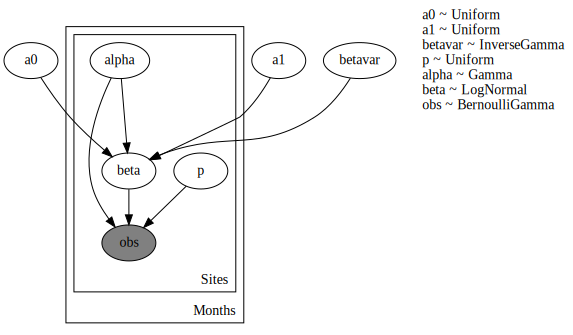

In [8]:
numpyro.render_model(
    parametric_dependency_model, model_args=(jdata,), render_distributions=True
)

In [9]:
with numpyro.handlers.seed(rng_seed=1):
    trace = numpyro.handlers.trace(parametric_dependency_model).get_trace(jdata)
print(numpyro.util.format_shapes(trace))

Trace Shapes:           
 Param Sites:           
Sample Sites:           
      a0 dist          |
        value          |
      a1 dist          |
        value          |
 betavar dist          |
        value          |
 Months plate        2 |
  Sites plate        5 |
       p dist      2 5 |
        value      2 5 |
   alpha dist      2 5 |
        value      2 5 |
    beta dist      2 5 |
        value      2 5 |
     obs dist      2 5 |
        value 1000 2 5 |


In [10]:
# Numpyro syntax for running MCMC
starttime = timeit.default_timer()

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(parametric_dependency_model)
# kernel = HMC(parametric_dependency_model)
# kernel = BarkerMH(parametric_dependency_model)
num_samples = 2000
num_warmup = 1000
mcmc = MCMC(
    kernel,
    num_warmup=num_warmup,
    num_samples=num_samples,
    #    chain_method="vectorized",
    num_chains=1,
)
mcmc.run(rng_key_, jdata)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

print("Time Taken:", timeit.default_timer() - starttime)

/tmp/ipykernel_21010/1994205226.py:21: UserWarning: Missing a plate statement for batch dimension -3 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc.run(rng_key_, jdata)
sample: 100%|██████████| 3000/3000 [00:46<00:00, 64.58it/s, 63 steps of size 5.88e-02. acc. prob=0.91] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        a0     -4.10      1.09     -4.08     -5.87     -2.44    581.40      1.00
        a1      4.01      1.51      3.97      1.65      6.34    584.84      1.00
alpha[0,0]      0.64      0.03      0.64      0.59      0.69   1609.40      1.00
alpha[0,1]      0.64      0.03      0.64      0.59      0.69   1537.34      1.00
alpha[0,2]      0.78      0.04      0.78      0.72      0.84   1453.82      1.00
alpha[0,3]      0.83      0.04      0.83      0.77      0.90   1239.12      1.00
alpha[0,4]      0.68      0.04      0.68      0.63      0.74   1791.30      1.00
alpha[1,0]      0.68      0.03      0.67      0.62      0.72   1272.57      1.00
alpha[1,1]      0.66      0.03      0.66      0.61      0.71   1631.97      1.00
alpha[1,2]      0.79      0.04      0.79      0.73      0.85   1201.41      1.00
alpha[1,3]      0.86      0.04      0.86      0.79      0.92   1310.76      1.00
alpha[1,4]      0.67      0

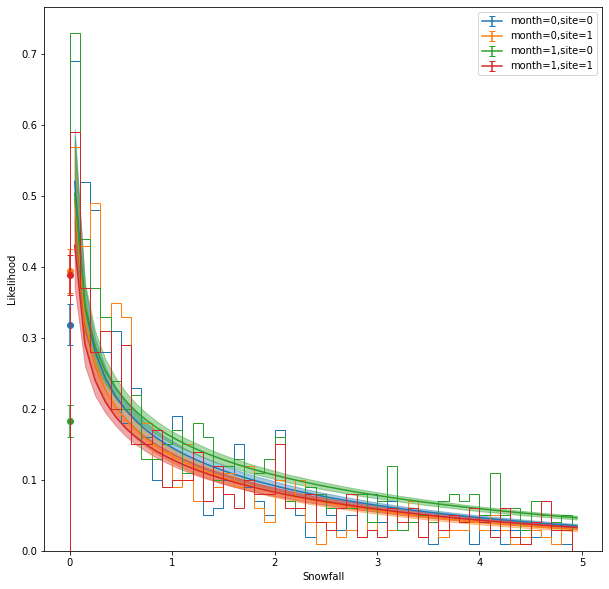

In [11]:
# Plotting the PDFs estimated for 2 different sites for January and February (The credible interval containing 95% of expected variation is also plotted)
data_list = [jan_data[:1000, :], feb_data[:1000, :]]

for k in np.arange(0, 2, 1):
    for j in np.arange(0, 2, 1):

        ps = jnp.expand_dims(samples_1[f"p"], -1)[:, k, j]
        alphas = jnp.expand_dims(samples_1[f"alpha"], -1)[:, k, j]
        scales = jnp.reciprocal(jnp.expand_dims(samples_1[f"beta"], -1))[:, k, j]

        bins = np.arange(0, 5, 0.1)
        bin_centers = bins + bins[1] / 2

        likelihood_values = ps * jgamma.pdf(bin_centers, a=alphas, loc=0, scale=scales)

        zero_likelihood_values = 1 - ps

        mean_l = jnp.mean(jnp.array(likelihood_values), axis=0)
        hpdi_l = hpdi(jnp.array(likelihood_values), 0.95)
        lower_l = hpdi_l[0]
        upper_l = hpdi_l[1]

        zero_mean_l = jnp.mean(jnp.array(zero_likelihood_values), axis=0)
        zero_hpdi_l = hpdi(jnp.array(zero_likelihood_values), 0.95)
        zero_lower_l = zero_hpdi_l[0]
        zero_upper_l = zero_hpdi_l[1]
        zero_lower_error = zero_mean_l - zero_lower_l
        zero_upper_error = zero_upper_l - zero_mean_l
        error = np.array([zero_lower_error[0], zero_upper_error[0]]).reshape(2, 1)

        data = data_list[k][:, j]
        bin_width = bins[1] - bins[0]
        p_data = len(data[data != 0]) / len(data)
        weight_value = p_data / bin_width / len(data[data != 0])
        weights = np.full(len(data[data != 0]), weight_value)

        color = next(plt.gca()._get_lines.prop_cycler)["color"]

        plt.hist(
            data[data != 0],
            bins=bins,
            histtype="step",
            stacked=True,
            fill=False,
            weights=weights,
            color=color,
        )

        plt.plot(bin_centers, mean_l, color=color)
        plt.fill_between(bin_centers, y1=lower_l, y2=upper_l, alpha=0.4, color=color)

        plt.plot(0, 1 - ps.mean(), marker="o", color=color)
        plt.errorbar(
            0,
            zero_mean_l,
            yerr=error,
            capsize=3,
            color=color,
            label=f"month={k},site={j}",
        )

plt.xlabel("Snowfall")
plt.ylabel("Likelihood")
plt.legend()

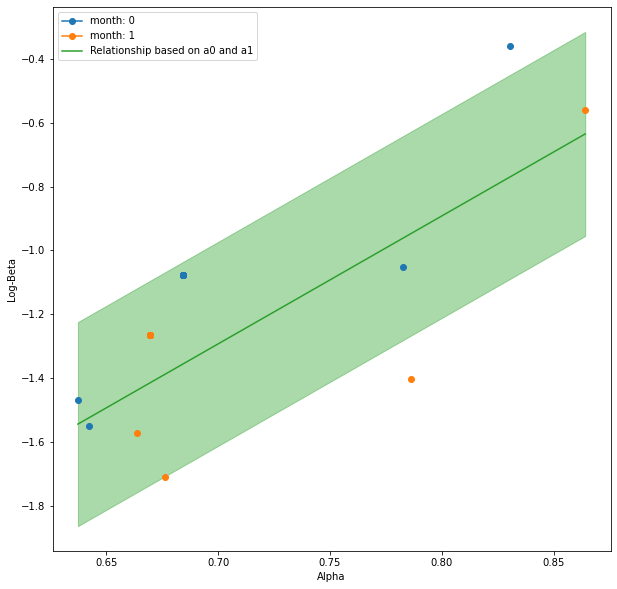

In [12]:
# Examining the parametric relationship between Alpha and Beta

alpha_mean_list = []
a0 = jnp.expand_dims(samples_1[f"a0"], -1)
a1 = jnp.expand_dims(samples_1[f"a1"], -1)
betavar = jnp.expand_dims(samples_1[f"betavar"], -1)
for k in np.arange(0, 2, 1):
    color = next(plt.gca()._get_lines.prop_cycler)["color"]
    for j in np.arange(0, 50, 1):
        alphas = jnp.expand_dims(samples_1[f"alpha"][:, k, j], -1)
        alpha_mean_list.append(jnp.mean(alphas))
        betas = jnp.expand_dims(samples_1[f"beta"][:, k, j], -1)
        plt.plot(
            jnp.mean(alphas),
            jnp.mean(jnp.log(betas)),
            marker="o",
            color=color,
            label=f"month: {k}",
        )

x = [jnp.min(jnp.array(alpha_mean_list)), jnp.max(jnp.array(alpha_mean_list))]
y = jnp.mean(a0) + jnp.mean(a1) * jnp.array(x)
color = next(plt.gca()._get_lines.prop_cycler)["color"]
plt.plot(x, y, label="Relationship based on a0 and a1", color=color)
plt.fill_between(
    x,
    y1=y - jnp.mean(betavar),
    y2=y + jnp.mean(betavar),
    alpha=0.4,
    color=color,
)
plt.xlabel("Alpha")
plt.ylabel("Log-Beta")
# Below is some code for plotting a non-repeating legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys())